In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD 
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

## Dataset

In [2]:
X = np.random.uniform(-1,1,(200,2))
Y = np.ones((200,1))
Y[(X[:,0] * X[:,1]) < 0] = 0

In [3]:
# Must be float32, as model parameters are internally float32
X_Train = torch.from_numpy(X[:100]).to(torch.float32)
X_Validation = torch.from_numpy(X[100:]).to(torch.float32)
Y_Train = torch.from_numpy(Y[:100]).to(torch.float32)
Y_Validation = torch.from_numpy(Y[100:]).to(torch.float32)

In [4]:
X_Train.shape, Y_Train.shape

(torch.Size([100, 2]), torch.Size([100, 1]))

## Visualize data

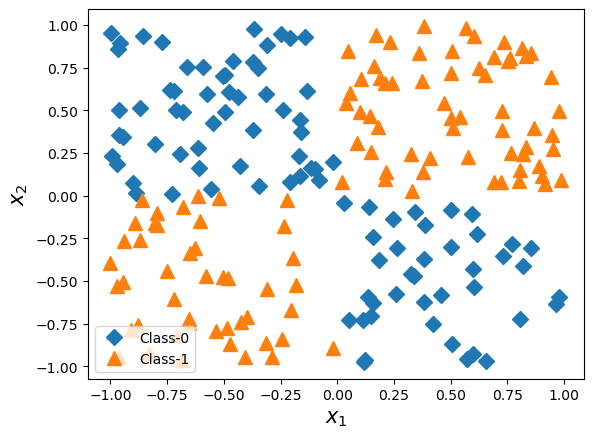

In [5]:
plt.plot(X[(Y==0).squeeze(),0],
         X[(Y==0).squeeze(),1],
         linestyle = "",
         marker = "D",
         markersize = 8)
plt.plot(X[(Y==1).squeeze(),0],
         X[(Y==1).squeeze(),1],
         linestyle = "",
         marker="^",
         markersize=10)

plt.xlabel("$x_1$", size=15)
plt.ylabel("$x_2$", size=15)

plt.legend(["Class-0", "Class-1"], loc=3)
plt.show()

## Dataloader iterator

In [6]:
dataset = TensorDataset(X_Train, Y_Train)
batch_size = 2
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)
next(iter(data))

[tensor([[ 0.0493,  0.8496],
         [ 0.8550, -0.3045]]),
 tensor([[1.],
         [0.]])]

# Base Line Model
- Logistic regression model

In [7]:
baseModel = nn.Sequential(nn.Linear(2,1),
                       nn.Sigmoid())
baseModel

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [8]:
learning_rate = 0.001
loss_func = nn.BCELoss()
optimizer = SGD(baseModel.parameters(), lr=learning_rate)

In [9]:
epoch = 200
Train_loss = [0] * epoch
Train_accuracy = [0] * epoch

Test_loss = [0] * epoch
Test_accuracy = [0] * epoch

def train(model):
    global Train_loss, Train_accuracy, Test_loss, Test_accuracy
    for i in range(epoch):
        for x_batch, y_batch in data:
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            Train_loss[i] += loss.item() * x_batch.size(0)        
            correct_count = ((pred>=0.5)==y_batch).sum().item() 
            Train_accuracy[i] += correct_count # No need to multiple by batch_size as correct_count is not mean
        Train_loss[i] /= len(data.dataset)
        Train_accuracy[i] /= len(data.dataset)

        with torch.no_grad():
            prediction = model(X_Validation)
            loss_1 = loss_func(prediction, Y_Validation)
            Test_loss[i] = loss_1
            crt_cnt = ((prediction>=0.5)==Y_Validation).sum()
            Test_accuracy[i] = crt_cnt/len(X_Validation)
         
        

In [10]:
train(baseModel)

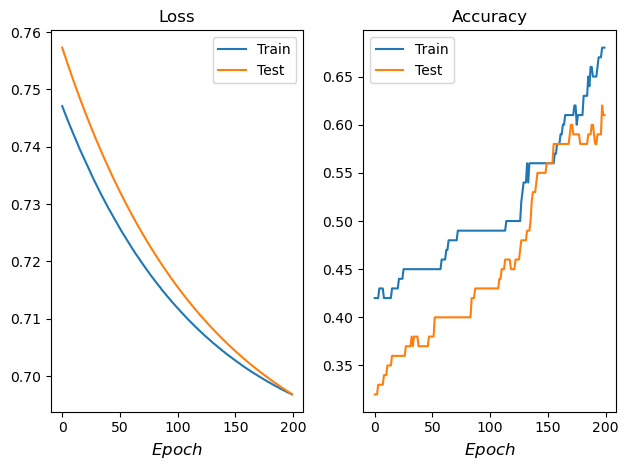

In [11]:
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), Train_loss)
plt.plot(np.arange(epoch), Test_loss)
plt.xlabel("$Epoch$", size=12)
plt.title("Loss")
plt.legend(["Train", "Test"])

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), Train_accuracy)
plt.plot(np.arange(epoch), Test_accuracy)
plt.xlabel("$Epoch$", size=12)
plt.title("Accuracy")
plt.legend(["Train", "Test"])
plt.tight_layout()

In [12]:
print(f"Final Accuracy :{Test_accuracy[-1]*100:.2f}%") 

Final Accuracy :61.00%


# Good model (Less efficient, but easy, method to create complex models)
- Try with Wider architecture : 1 layer, more neuron units
- Try with Deeper architecture: 1 to 4 layer, fixed hidden units

In [13]:
torch.manual_seed(1)
Model = nn.Sequential(nn.Linear(2,100),
                     nn.ReLU(),
                     nn.Linear(100,1),
                     nn.Sigmoid())
Model

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)

In [14]:
lossfunc = nn.BCELoss()
learning_rate = 0.001
optimizer = SGD(Model.parameters(), lr=learning_rate)

In [15]:
epoch = 200
Train_loss = [0] * epoch
Train_accuracy = [0] * epoch

Test_loss = [0] * epoch
Test_accuracy = [0] * epoch

train(Model)

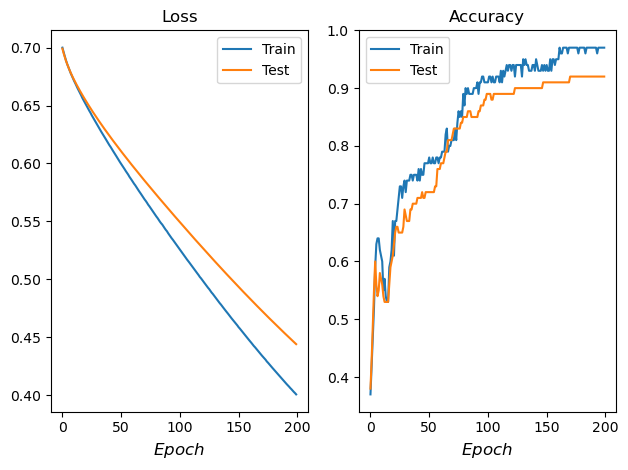

In [16]:
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), Train_loss)
plt.plot(np.arange(epoch), Test_loss)
plt.xlabel("$Epoch$", size=12)
plt.title("Loss")
plt.legend(["Train", "Test"])

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), Train_accuracy)
plt.plot(np.arange(epoch), Test_accuracy)
plt.xlabel("$Epoch$", size=12)
plt.title("Accuracy")
plt.legend(["Train", "Test"])
plt.tight_layout()

In [17]:
print(f"Final Accuracy :{Test_accuracy[-1]*100:.2f}%")  

Final Accuracy :92.00%


## Observations
---

### Baseline model
- 1 neuron   : 61% Accuracy

### Single hidden layer
- 10 neurons : 71% Accuracy of Validation data
- 50 neurons : 88% Accuracy of Validation data
- 100 neurons: 92% Accuracy of Validation data & 97% Accuracy of Train data

<br>

- As number of neurons per layer increases(when NN widens) the accuracy or the capacity of the model increases. At the same time it might lead to overfitting

### Multiple layer: Fix with 4 neuron per layer
- 1 Layer: 69% Accuracy of Validation data
- 2 Layer: 53%
- 3 Layer: 53%
- 4 Layer: 53%

Increasing neuron per unit can possible increase the accuracy. So a Architecture with sufficiently deep and wider can achieve good accuracy.

# Good model (More efficient/flexible method to create complex models using nn.Module)
- Complex models means multiple inout, output, **intermediate branches** etc.
- Using nn.ModuleList object to stack layers
- More concise method to create complex models

In [18]:
torch.manual_seed(1)
class NewModel(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2,40)
        a1 = nn.ReLU()
        l2 = nn.Linear(40,50)
        a2 = nn.ReLU()
        l3 = nn.Linear(50,1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3] # Stacking layers in order
        self.module_list = nn.ModuleList(l)
    def forward(self,x):
        for fn in self.module_list:
            x = fn(x)
        return x
    # For visualizing
    def predict(self, x):
        x = torch.tensor(x)
        pred = self.forward(x)
        return (pred >= 0.5).squeeze()
effModel = NewModel()
effModel

NewModel(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
learning_rate = 0.001
loss_func = nn.BCELoss()
optimizer = SGD(effModel.parameters(), lr=learning_rate)

In [20]:
epoch = 200
Train_loss = [0] * epoch
Train_accuracy = [0] * epoch

Test_loss = [0] * epoch
Test_accuracy = [0] * epoch

train(effModel)

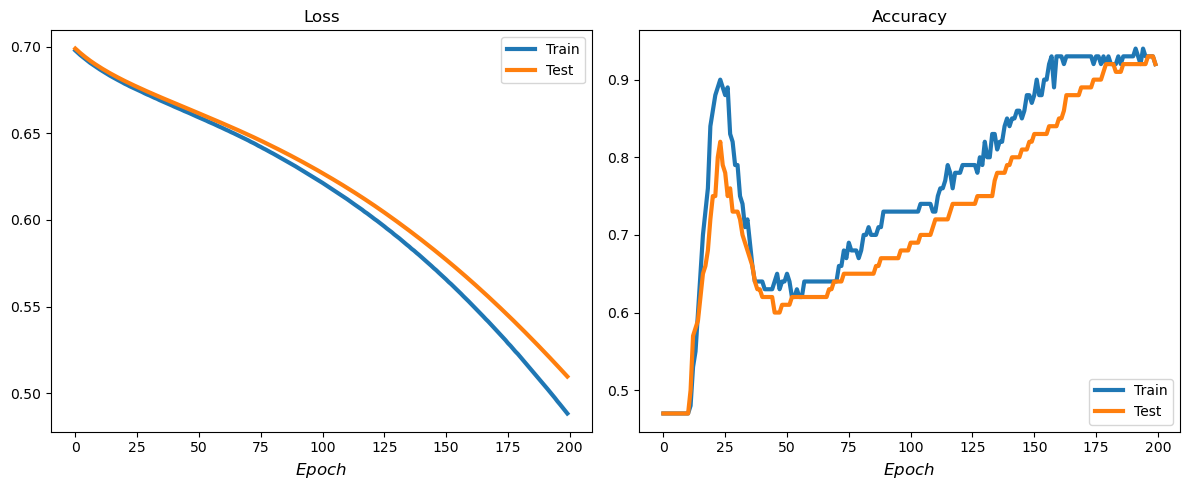

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), Train_loss, lw=3)
plt.plot(np.arange(epoch), Test_loss, lw=3)
plt.xlabel("$Epoch$", size=12)
plt.title("Loss")
plt.legend(["Train", "Test"])

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), Train_accuracy, lw=3)
plt.plot(np.arange(epoch), Test_accuracy, lw=3)
plt.xlabel("$Epoch$", size=12)
plt.title("Accuracy")
plt.legend(["Train", "Test"])
plt.tight_layout()

In [22]:
print(f"Final Accuracy :{Test_accuracy[-1]*100:.2f}%")  

Final Accuracy :92.00%


### Using mlxtend to visualize decision boundary
- Upon validation test data
- Make sure:
    - Input for plot_decision_regions must be numpy array
        - y must be integer type, squeeze it to rank-1
    - plot_decision_regions also calls the predict method inside the Model which inturn calls forward method which requires tensor. So typecast it.    

Text(0, 0.5, '$x_2$')

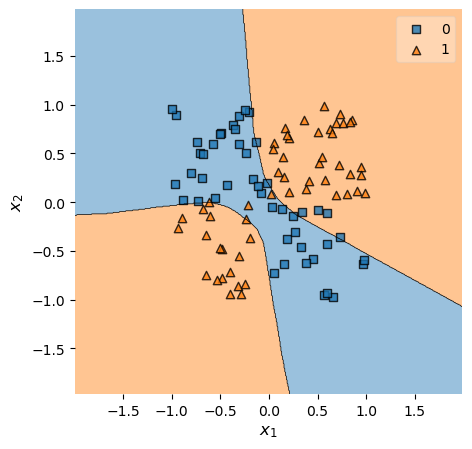

In [23]:
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(5,5))
plot_decision_regions(X = X_Validation.numpy(),
                      y = Y_Validation.numpy().astype('int').squeeze(),
                      clf = effModel)
plt.xlabel("$x_1$", size=12)
plt.ylabel("$x_2$", size=12)

# Custom layer + nn.Module Subclass
* Using  Custom layer (say noise layer) by subclassing nn.Module. Also implementing the architecture using nn.Module
* Custom layer computation --> w(x+noise) + b

#### Layer

In [24]:
class NoiseLinear(nn.Module):
    def __init__(self, input_size, output_size, noise=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size).fill_(0)
        self.w = nn.Parameter(w) # To keep track of gradient for the layer parameters
        # Glorot random initialization
        nn.init.xavier_uniform_(self.w)
        
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise = noise
        
    def forward(self, x, train=True):
        if train:
            noise = torch.normal(0, self.noise, x.shape)
            x = torch.add(x, noise)
        return torch.add(x @ self.w, self.b)
            

#### Model

In [25]:
class NoiseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoiseLinear(2,40, 0.07)
        a1 = nn.ReLU()
        l2 = nn.Linear(40,50)
        a2 = nn.ReLU()
        l3 = nn.Linear(50,1)
        a3 = nn.Sigmoid()
        l = [a1,l2,a2,l3,a3]
        self.module_list = nn.ModuleList(l)
    def forward(self, x, train=True):
        x = self.l1(x, train)
        for fn in self.module_list:
            x = fn(x)
        return x
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x, train=False)
        return (pred >= 0.5)
torch.manual_seed(1)    
nm = NoiseModel()
nm

NoiseModel(
  (l1): NoiseLinear()
  (module_list): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=40, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

### Training

In [26]:
loss_func = nn.BCELoss()
learning_rate = 0.03 ## 0.001 ## Learning rate is very low, increase it
optimizer = SGD(nm.parameters(), lr=learning_rate)

In [27]:
epoch = 200
Train_loss = [0] * epoch
Train_accuracy = [0] * epoch

Test_loss = [0] * epoch
Test_accuracy = [0] * epoch

for i in range(epoch):
    for x_batch, y_batch in data:
        pred = nm(x_batch)
        loss = loss_func(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        Train_loss[i] += loss.item() * x_batch.size(0)
        correct_cnt = ((pred >= 0.5)==y_batch).sum().item()
        Train_accuracy[i] += correct_cnt
    Train_loss[i] /= len(data.dataset)
    Train_accuracy[i] /= len(data.dataset)
    with torch.no_grad():
        prediction = nm(X_Validation, False)
        loss_1 = loss_func(prediction, Y_Validation)
        Test_loss[i] = loss_1
        crt_cnt = ((prediction>=0.5)==Y_Validation).sum()
        Test_accuracy[i] = crt_cnt/len(X_Validation)

In [28]:
print(f"Final Accuracy :{Test_accuracy[-1]*100:.2f}%")  

Final Accuracy :95.00%


### Visualisation

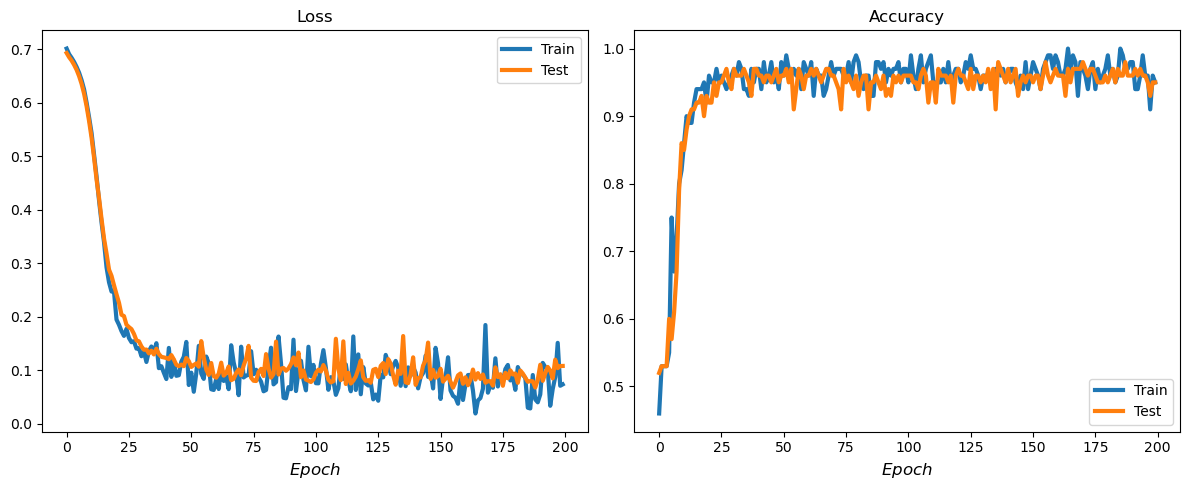

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), Train_loss, lw=3)
plt.plot(np.arange(epoch), Test_loss, lw=3)
plt.xlabel("$Epoch$", size=12)
plt.title("Loss")
plt.legend(["Train", "Test"])

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), Train_accuracy, lw=3)
plt.plot(np.arange(epoch), Test_accuracy, lw=3)
plt.xlabel("$Epoch$", size=12)
plt.title("Accuracy")
plt.legend(["Train", "Test"])
plt.tight_layout()

Text(0, 0.5, '$x_2$')

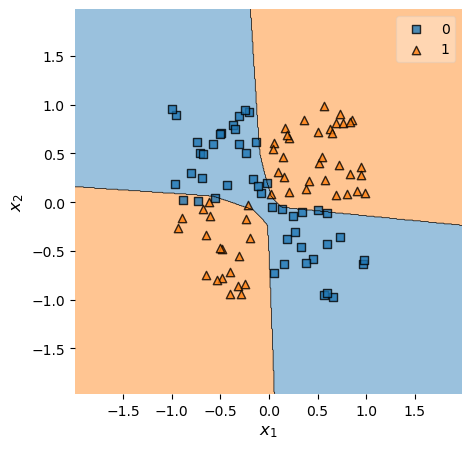

In [30]:
plt.figure(figsize=(5,5))
plot_decision_regions(X = X_Validation.numpy(),
                      y = Y_Validation.numpy().astype('int').squeeze(),
                      clf = nm)
plt.xlabel("$x_1$", size=12)
plt.ylabel("$x_2$", size=12)